# CNN_eda


## Mount Google Drive

In [1]:
# Colab 사용시
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install

In [2]:
# !java -version
%pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Library

In [3]:
# data
import pandas as pd
import pickle

# preprocessing
from konlpy.tag import Komoran
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# model
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# visualization
import matplotlib.pyplot as plt
import seaborn as sn

# env
import os
from tqdm import tqdm
# import hangul_font

## GPU Setting

In [4]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


## Hyper_parameters

In [5]:
# Colab
DATA_DIR = '/content/drive/MyDrive/miso/sentiment/data/'
SAVE_DIR = '/content/drive/MyDrive/miso/sentiment/model/CNN_eda/'
LOAD_DIR = '/content/drive/MyDrive/miso/sentiment/model/CNN_eda/'

# Model
# MAX_LEN -> 패딩 단계에서 설정
OUTPUT_DIM = 512 #Embedding
FILTERS = 256 #Con1D
KERNEL_SIZE = 3 #Con1D
UNITS = 256 #Dense
RATE = 0.3 #Dropout
OUTPUT = 6 #Dense

# Evaluation
EPOCHS = 10
VERBOSE = 1
BATCH_SIZE = 512
PATIENCE = 5
VALIDATION_SPLIT=0.2

## Load Data

In [6]:
df = pd.read_csv(DATA_DIR+'eda_final_sentiment.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667870 entries, 0 to 667869
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    667870 non-null  object
 1   label   667870 non-null  object
dtypes: object(2)
memory usage: 10.2+ MB


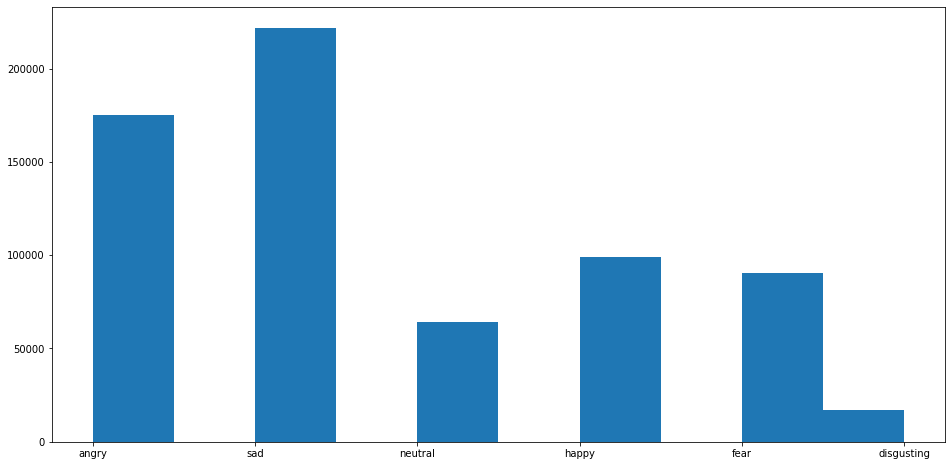

In [8]:
label = df['label']

plt.figure(figsize=(16, 8))
plt.hist(label)
plt.show()

### Train, Test split

In [9]:
X = df.text
y = df.label

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=34, stratify=y
)

In [10]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('\nX_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (534296,)
y_train shape:  (534296,)

X_test shape:  (133574,)
y_test shape:  (133574,)


## Train Data PreProcessing

### Tokenization

In [11]:
komoran = Komoran()

# 불용어(Stop Words) 제거
stop_pos_tags =  ['IC', 'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX',
                   'EF', 'ETN', 'ETM', 'XSA', 'SF', 'SP', 'SS', 'SE', 'SO', 'SL', 'SH',
                   'SW', 'NF', 'NV', 'SN', 'NA']

#어간 원형 복원 (Lemmatization)
#동사와 형용사의 경우에는 어간(Stem)에 '다'를 붙여서 기본형으로 복원
def tokenize(corpus, stop_pos_tags):
    result = []
    pairs = komoran.pos(corpus)
    for pair in pairs:
        morph, pos = pair
        if pos not in stop_pos_tags:
            if pos in ['VV', 'VA', 'VX', 'VCP', 'VCN']:
                morph = morph + '다'
            result.append(morph)
    return result

In [12]:
# 토큰을 만들고 리스트에 저장
clean_train_text = []
for sample in tqdm(X_train):
    clean_train_text.append(tokenize(sample, stop_pos_tags))

100%|██████████| 534296/534296 [05:57<00:00, 1492.89it/s]


In [13]:
clean_train_text[:3]

[['근데', '면접', '오히려', '더', '잘', '보다', '았'],
 ['많이', '놀라다', '았'],
 ['앉다', '아서', '일', '하다', '니까', '허리', '너무', '아프다']]

## Test Data PreProcessing

### Tokenization

In [14]:
# 토큰을 만들고 리스트에 저장
clean_test_text = []
for sample in tqdm(X_test):
    clean_test_text.append(tokenize(sample, stop_pos_tags))

100%|██████████| 133574/133574 [01:48<00:00, 1225.99it/s]


### Vectorization

In [15]:
tokenizer_name = 'tokenizer.pickle'
save_path = os.path.join(SAVE_DIR, tokenizer_name)

tokenizer = Tokenizer(oov_token = True)

try:
    tokenizer.fit_on_texts(clean_train_text)
    train_sequences = tokenizer.texts_to_sequences(clean_train_text)
    test_sequences = tokenizer.texts_to_sequences(clean_test_text)
except:
    print('Already tokenized')

with open(save_path, 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

vocab_size = len(tokenizer.word_index)+1 # 단어의 수
vocab_size

train_sequences[:3]

[[206, 230, 890, 63, 42, 21, 5],
 [53, 229, 5],
 [687, 15, 32, 3, 82, 351, 13, 109]]

### Set vocab_size

In [16]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(VOCAB_SIZE)

13268


### Get vocab items

In [ ]:
# token_dic = tokenizer.word_counts
# d2 = sorted(token_dic.items(), key=lambda x: x[1], reverse=True)
# print("sorted")
# print(d2)

### Padding

텍스트의 최대 길이 : 62
텍스트의 평균 길이 : 12.660396110021411


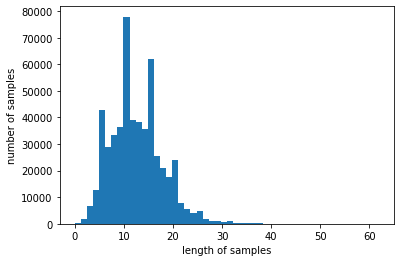

In [18]:
print('텍스트의 최대 길이 :',max(len(text) for text in train_sequences))
print('텍스트의 평균 길이 :',sum(map(len, train_sequences))/len(train_sequences))
plt.hist([len(text) for text in train_sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
trunc_type = 'post'
padding_type = 'post'
MAX_LEN = int(max(len(text) for text in train_sequences) * 95 / 100)

X_train = pad_sequences(train_sequences, maxlen=MAX_LEN, padding=padding_type, truncating=trunc_type)
X_test= pad_sequences(test_sequences, maxlen=MAX_LEN, padding=padding_type, truncating=trunc_type)

In [20]:
print(X_train[:3])

[[206 230 890  63  42  21   5   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [ 53 229   5   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [687  15  32   3  82 351  13 109   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]]


### Labeling

In [21]:
y_train.unique()

array(['happy', 'fear', 'sad', 'angry', 'neutral', 'disgusting'],
      dtype=object)

In [22]:
emo_dic = {
    'angry': 0, 'disgusting': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5
}

In [23]:
y_train = y_train.replace(emo_dic)
y_test = y_test.replace(emo_dic)
y_train.unique()

array([3, 2, 5, 0, 4, 1])

## Model definition

In [24]:
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=OUTPUT_DIM, mask_zero=True))
model.add(Dropout(rate=RATE))
model.add(Conv1D(filters=FILTERS,  kernel_size=KERNEL_SIZE, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=UNITS, activation='relu'))
model.add(Dropout(rate=RATE))
model.add(Dense(units=OUTPUT, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=VERBOSE, patience=PATIENCE, restore_best_weights=True)
mcp = ModelCheckpoint(SAVE_DIR + 'best-model.h5', monitor='val_accuracy', mode='max', verbose=VERBOSE, save_best_only=True)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train Model

In [25]:
# !pip install tensorflow==2.7.0


In [26]:
history = model.fit(
    X_train, y_train, epochs=EPOCHS, callbacks=[es, mcp], batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT
)

Epoch 1/10
835/835 [==============================] - ETA: 0s - loss: 0.5820 - accuracy: 0.7856
Epoch 00001: val_accuracy improved from -inf to 0.87233, saving model to /content/drive/MyDrive/miso/sentiment/model/CNN_eda/best-model.h5
835/835 [==============================] - 39s 30ms/step - loss: 0.5820 - accuracy: 0.7856 - val_loss: 0.3605 - val_accuracy: 0.8723
Epoch 2/10
833/835 [============================>.] - ETA: 0s - loss: 0.3246 - accuracy: 0.8860
Epoch 00002: val_accuracy improved from 0.87233 to 0.90242, saving model to /content/drive/MyDrive/miso/sentiment/model/CNN_eda/best-model.h5
835/835 [==============================] - 21s 25ms/step - loss: 0.3245 - accuracy: 0.8861 - val_loss: 0.2830 - val_accuracy: 0.9024
Epoch 3/10
834/835 [============================>.] - ETA: 0s - loss: 0.2496 - accuracy: 0.9134
Epoch 00003: val_accuracy improved from 0.90242 to 0.91755, saving model to /content/drive/MyDrive/miso/sentiment/model/CNN_eda/best-model.h5
835/835 [==============

## Test Model

In [27]:
loaded_model = load_model(SAVE_DIR + 'best-model.h5')
loss, acc = loaded_model.evaluate(X_test, y_test)

print('Test loss:', loss)
print('Test accuracy:', acc)

4175/4175 [==============================] - 9s 2ms/step - loss: 0.2102 - accuracy: 0.9348
Test loss: 0.21019810438156128
Test accuracy: 0.9348076581954956


### Visualization

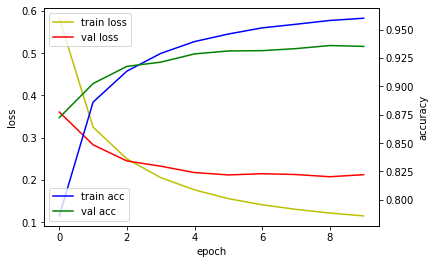

In [28]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## Save Model

In [29]:
model_name = 'trained-model.h5'

# Save model and weights
model_path = os.path.join(SAVE_DIR, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/MyDrive/miso/sentiment/model/CNN_eda/trained-model.h5 


## Evaluation

### confusion matrix

In [30]:
y_pred = loaded_model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
print(y_pred)

[5 5 5 ... 2 4 5]


[[32824   152   272   296   287  1166]
 [   64  3150    38    23    56    64]
 [  279    65 16782   187   278   531]
 [  279    26   180 18460   344   537]
 [  271   116   178   260 11642   387]
 [  828    63   490   521   470 42008]]


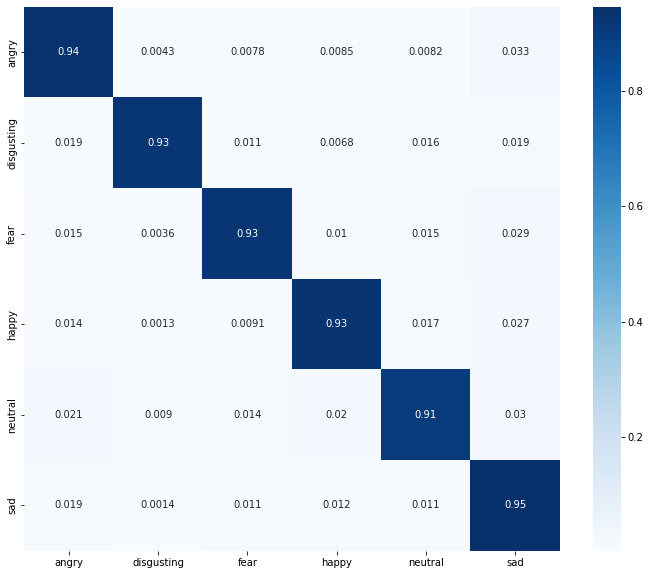

In [31]:
# constant for classes
classes = ('angry', 'disgusting', 'fear', 'happy', 'neutral', 'sad')

# Build confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix/cf_matrix.sum(axis=1).reshape(6, 1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True, cmap='Blues')
plt.savefig(SAVE_DIR + 'output.png')

### precision, recall, f1 score

In [32]:
acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred, average='macro')
re_score = recall_score(y_test, y_pred, average='macro')
f1_score = f1_score(y_test, y_pred, average='macro')
print("accuracy_score: ", acc_score)
print("precision_score: ", prec_score)
print("recall_score: ", re_score)
print("f1_score: ", f1_score)

accuracy_score:  0.9348076721517661
precision_score:  0.9220842839126401
recall_score:  0.929194017111314
f1_score:  0.9255175857614827


## Load Model

In [33]:
def load_tokenizer(path):
    with open(path, 'rb') as f:
        tokenizer = pickle.load(f)
    return tokenizer

model_name = 'trained-model.h5'
tokenizer_name = 'tokenizer.pickle'
model_path = os.path.join(LOAD_DIR, model_name)
tokenizer_path = os.path.join(LOAD_DIR, tokenizer_name)

model = load_model(model_path)
tokenizer = load_tokenizer(tokenizer_path)


In [34]:
def getResult(predict) :
    highest = 0
    highestIdx = 0
    for x in range (0,len(predict)) :
        if(predict[x] > highest) :
            highestIdx = x
            highest =predict[x]
    return highestIdx

def predict_sentiment(text, model):
    tokens = []
    tokenized = tokenize(text, stop_pos_tags)
    if(len(tokenized) == 0) :
        return "너무 짧아"
    tokens.append(tokenized)
    tokens = tokenizer.texts_to_sequences(tokens)
    x_test = pad_sequences(tokens, maxlen=MAX_LEN)
    predict = model.predict(x_test)
    # print(predict)
    result = getResult(predict[0])
    if result == 0 :
        return 'angry'
    elif result == 1 :
        return 'disgusting'
    elif result == 2 :
        return 'fear'
    elif result == 3 :
        return 'happy'
    elif result == 4 :
        return 'neutral'
    elif result == 5 :
        return 'sad'

# TEST

angry 라벨에 대한 예측

In [35]:
predict_sentiment("연락이 또 안돼. 짜증난다.", model)

'angry'

disgusting 라벨에 대한 예측

In [36]:
predict_sentiment("음식물 냄새가 너무 심해.", model)

'disgusting'

fear 라벨에 대한 예측

In [37]:
predict_sentiment("갑자기 사라질까봐 무서워.", model)

'sad'

happy라벨에 대한 예측

In [38]:
predict_sentiment("부모님께서 건강하다는 사실에 대해 감사하고 있어.", model)

'happy'

neutral라벨에 대한 예측

In [39]:
predict_sentiment("지금 밥 먹으러 가는중이야.", model)

'neutral'

sad라벨에 대한 예측

In [40]:
predict_sentiment("강아지가 세상을 떠났어.", model)

'neutral'

## 결과

해당 모델은 CNN을 활용하여 6가지 감정 (angry, sad, fear, disgusting, neutral, happy)으로 라벨링된 문장을 분류하는 감정 다중 분류기이다.  
모델 학습에 사용된 데이터는 총 972,056문장이다. 앞서 결측치 제거 중복 문장 제거 등의 전처리하는 과정을 거친 데이터이다. 이 데이터를 8:2의 비율로 train data / test data로 나누어 준 후 불용어 제거, 토큰화, 워드 임베딩, 패딩 등의 데이터 전처리를 진행한다. 불용어 제거는 제거해야할 각 단어를 직접 명시해주는것이 아닌 품사를 지정하여 태깅된 품사의 단어를 제거해주는 방식으로 진행했다. 토큰화는 한국어 전처리 패키지인 KoNLPy에 있는 Komoran 형태소 분석기를 사용했다. 패딩 과정에서 하이퍼파라미터의 maxlen값은 텍스트 최대 길이의 95퍼센트 정도로 맞춰주었다.  
모델의 구조는 Embedding층 / Dropout층 / Convolution층 / MaxPooling층 / Dense층 / Dropout층 / Dense 출력층 으로 나뉜다. 과대적합 방지를 위한 Dropout과 Earlystopping을 적용해주었다. 또한 모델을 학습하는 과정에서 검증 데이터를 따로 떼어서 검증을 수행하는 Validation_split 옵션도 적용해 주었다. 모델의 각 은닉층 또는 출력층에서 사용된 하이퍼 파라미터는 노트북 상단의 Hyper_parameters에서 찾아볼 수 있다.
epoch 19에서 early stopping 되었고 test data로 평가 결과는 loss: 0.1299 / accuracy: 0.9671이다.
Confusion Matrix를 보면 eda를 적용하지 않은 데이터에 비해 모두 높은 정확도를 보인다. 데이터의 불균형은 여전히 존재하지만 충분하게 데이터를 늘려주었기 때문에 높은 정확도가 나오지 않았을까 싶다.